In [49]:
import os
import torch
from torch import nn
from torchviz import make_dot
from IPython.display import Image, display

import eval
import test_stuff_functions as tsf

from libs.core import load_config
from libs.datasets import make_dataset, make_data_loader
from libs.modeling import make_meta_arch
from libs.utils import fix_random_seed

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evaluate Pretrained

In [26]:
eval.run(config='configs/UMMAFormer/psynd_byola.yaml', ckpt='Pretrained/psynd_byola/epoch_015.pth.tar', epoch=15)

{'dataset': {'audio_feat_folder': './data/Psynd/feats/byola',
             'audio_file_ext': None,
             'audio_input_dim': 2048,
             'crop_ratio': [0.9, 1.0],
             'default_fps': None,
             'downsample_rate': 1,
             'feat_stride': 1,
             'file_ext': '.npy',
             'file_prefix': 'none',
             'force_upsampling': True,
             'input_dim': 0,
             'json_file': './data/Psynd/annotations/metadatabyola.json',
             'max_seq_len': 768,
             'num_classes': 1,
             'num_frames': 1,
             'trunc_thresh': 0.5},
 'dataset_name': 'psynd',
 'devices': [0],
 'init_rand_seed': 1234567891,
 'loader': {'batch_size': 8, 'num_workers': 4},
 'model': {'audio_input_dim': 2048,
           'backbone_arch': (2, 2, 5),
           'backbone_type': 'convHRLRFullResSelfAttTransformerRevised',
           'embd_dim': 256,
           'embd_kernel_size': 3,
           'embd_with_ln': True,
           'fpn_dim':

In [27]:
file_path = '/home/ben/Thesis/UMMAFormerTest/Pretrained/psynd_byola/test_results.txt'
detection_df, proposal_df = tsf.format_results_as_matrix(file_path)

# Display the matrices
print("Detection Results:")
print(detection_df)

print("\nProposal Results:")
print(proposal_df)

Detection Results:
   average-mAP  mAP@0.50  mAP@0.55  mAP@0.60  mAP@0.65  mAP@0.70  mAP@0.75  \
0        96.97     100.0     100.0     100.0     100.0     100.0    98.574   

   mAP@0.80  mAP@0.85  mAP@0.90  mAP@0.95  
0    98.574    97.322    95.363     79.87  

Proposal Results:
    AR@10   AR@20   AR@50  AR@100
0  97.595  97.595  97.595  97.595


## Build Model

In [ ]:
# model to load
config='configs/UMMAFormer/psynd_byola.yaml'
ckpt='Pretrained/psynd_byola/epoch_015.pth.tar'
epoch=15
_ = fix_random_seed(0, include_cuda=True)

In [ ]:
# load config
if os.path.isfile(config):
    cfg = load_config(config)

In [8]:
# data
val_dataset = make_dataset(
    cfg['dataset_name'], False, cfg['test_split'], **cfg['dataset']
)
# set bs = 1, and disable shuffle
val_loader = make_data_loader(
    val_dataset, False, None, 1, cfg['loader']['num_workers']
)

['test'] subset has 79 videos


In [19]:
sample = next(iter(val_loader))
sample[0]["feats"].shape

torch.Size([2048, 768])

In [21]:
# model
model = make_meta_arch(cfg['model_name'], **cfg['model'])
# only one gpu
#model = nn.DataParallel(model, device_ids=cfg['devices'])

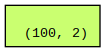

In [51]:
# Generate a computational graph using torchviz
model.eval()
sample_input = sample 
output = model(sample_input)  # Forward pass through the model
graph = make_dot(output[0]['segments'], params=dict(model.named_parameters()))  # Create the graph
# Render the graph and display it in the notebook
graph.format = "png"  # Set the format to PNG
graph.render("model_visualization", format="png", cleanup=True)  # Render the graph and clean up intermediate files
display(Image("model_visualization.png"))  # Display the PNG in the notebook